The maximum value of the quantity $r^2v^2 \times f(\epsilon)$ is $2.884 \times 10^{-3}$; the maximum binding energy $\epsilon_{\max}$ is $1/2$; and the
maximum speed of a particle $v_{\max}$ is $\sqrt{2\epsilon_{\max}}$.

Draw a pair of uniform random numbers with $r_r \in [0, r_T)$ and $v_r \in [0, v_{\max})$. Then we compare the quantity $(r_r/a)^2(v_r^2/(M/a))f(\epsilon(r_r, v_r))$ and its maximum value with another uniform random variable $xi_i$ and accept or reject your draw the phase space accordingly.


In [153]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def get_potential_psi(r):
    # Dimensionless potential Psi = -Phi * (a/GM)
    return (2 * r + 1) / (2 * (r + 1)**2)

def analytic_f(epsilon):
    # Avoid division by zero at eps=0.5
    eps = np.minimum(epsilon, 0.499999)
    sqrt_arg = (2 * eps) / (1 - 2 * eps)
    term1 = ((3 - 4 * eps) * np.sqrt(2 * eps)) / (1 - 2 * eps)
    term2 = 3 * np.arcsinh(np.sqrt(sqrt_arg))
    val = (3 / (2 * np.pi**3)) * (term1 - term2)
    return np.where(epsilon <= 0, 0, val)

def analytic_g(epsilon):
    # Density of states
    # Avoid division by zero at eps=0
    eps = np.maximum(epsilon, 1e-6)
    termA_num = (3 - 14*eps - 8*eps**2)
    termA = np.sqrt(1 - 2*eps) * termA_num / (12 * eps**2)
    termB_num = (1 - 6*eps + 16*eps**2)
    termB_denom = (2 * eps)**2.5
    acos_arg = -np.sqrt(1 - 2*eps)
    termB = (termB_num / termB_denom) * np.arccos(acos_arg)
    val = 8 * np.pi**2 * (termA - np.pi + termB)
    return val

def analytic_dM_de(epsilon):
    # dM/de = f(e) * g(e)
    return analytic_f(epsilon) * analytic_g(epsilon)

def analytic_rho(r, M=1, a=1):
    return (3 * M * a) / (4 * np.pi * (r + a)**4)

In [181]:
def generate_realisation(n_particles, q_max=0.002, r_trunc=100):
    particles_r = []
    particles_v = []

    batch_size = 50000

    while len(particles_r) < n_particles:
        r_batch = np.random.uniform(0, r_trunc, batch_size) # r_trunc = 100
        v_batch = np.random.uniform(0, 1.0, batch_size)

        psi = get_potential_psi(r_batch)
        eps = psi - 0.5 * v_batch**2

        mask = (eps > 0) & (eps < 0.5)

        r_cand = r_batch[mask]
        v_cand = v_batch[mask]
        eps_cand = eps[mask]

        if len(r_cand) == 0: continue

        f_val = analytic_f(eps_cand)
        w = (r_cand**2) * (v_cand**2) * f_val

        # Rejection
        prob = w / q_max
        prob = np.minimum(prob, 1.0)

        xi = np.random.uniform(0, 1, len(r_cand))
        accept = xi < prob

        particles_r.extend(r_cand[accept])
        particles_v.extend(v_cand[accept])

    return np.array(particles_r[:n_particles]), np.array(particles_v[:n_particles])

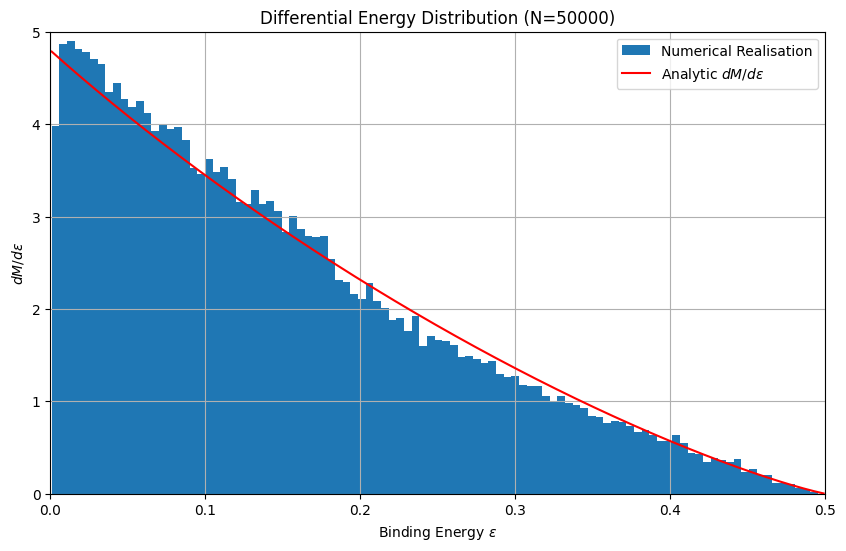

In [155]:
N = 50000
r_data, v_data = generate_realisation(N, 0.002, 300)
psi_data = get_potential_psi(r_data)
energies = psi_data - 0.5 * v_data**2

plt.figure(figsize=(10, 6))
plt.hist(energies, bins=100, density=True, label='Numerical Realisation')
e_grid = np.linspace(0.001, 0.499, 500)
dM_de = analytic_f(e_grid) * analytic_g(e_grid)

plt.plot(e_grid, dM_de, 'r-', label='Analytic $dM/d\\epsilon$')
plt.title(f'Differential Energy Distribution (N={N})')
plt.xlabel(r'Binding Energy $\epsilon$')
plt.ylabel(r'$dM/d\epsilon$')
plt.xlim(0, 0.5)
plt.ylim(0, 5)
plt.legend()
plt.grid(True)
plt.show()

In [180]:
def spherical_to_cartesian(magnitudes):
    '''
    Takes a 1D array of magnitudes (r or v) and projects them
    onto random directions on a sphere.
    Returns (N, 3) array of [x, y, z] or [vx, vy, vz].
    '''
    N = len(magnitudes)

    # Generate random angles
    u1 = np.random.uniform(0, 1, N)
    u2 = np.random.uniform(0, 1, N)

    phi = 2 * np.pi * u1
    costheta = 2 * u2 - 1
    sintheta = np.sqrt(1 - costheta**2)

    # Spherical to Cartesian projection
    x = magnitudes * sintheta * np.cos(phi)
    y = magnitudes * sintheta * np.sin(phi)
    z = magnitudes * costheta

    return np.column_stack((x, y, z))


def analyse_realisation(r_trunc_list=[10, 50, 100, 300, 1000]):
    N = 5000
    results = []
    print(f"{'r_trunc':<10} | {'Theoretical M(r_T)':<20} | {'Missing Mass %':<15}")
    print("-" * 55)

    for r_t in r_trunc_list:
        # Theoretical mass enclosed
        m_theoretical = (r_t / (r_t + 1.0))**3
        missing_pct = (1.0 - m_theoretical) * 100

        print(f"{r_t:<10} | {m_theoretical:.6f}             | {missing_pct:.4f}%")

        # Generate the specific realisation for r_trunc = 100
        if r_t == 100:
            r_scalar, v_scalar = generate_realisation(N, 0.002, r_t)

            # Convert to Cartesian
            pos = spherical_to_cartesian(r_scalar)
            vel = spherical_to_cartesian(v_scalar)

            # Renormalise Mass
            mass_particle = 1.0 / N
            masses = np.ones(N) * mass_particle

            # Save or Return these for the N-body code
            final_pos = pos
            final_vel = vel
            final_mass = masses

    return final_pos, final_vel, final_mass

pos, vel, mass = analyse_realisation([10, 50, 100, 300])

r_trunc    | Theoretical M(r_T)   | Missing Mass % 
-------------------------------------------------------
10         | 0.751315             | 24.8685%
50         | 0.942322             | 5.7678%
100        | 0.970590             | 2.9410%
300        | 0.990066             | 0.9934%


In [183]:
def generate_data(N=5000, q_max=0.002, r_trunc=100):
    '''
    Generates N particles.
    '''
    particles_r = []
    batch_size = N * 5
    while len(particles_r) < N:
        r = np.random.uniform(0, r_trunc, batch_size)
        v = np.random.uniform(0, 1.0, batch_size)
        psi = get_potential_psi(r)
        eps = psi - 0.5 * v**2
        mask = (eps > 0) & (eps < 0.5)
        r, v, eps = r[mask], v[mask], eps[mask]
        w = (r**2) * (v**2) * analytic_f(eps)
        prob = w / q_max
        accept = np.random.uniform(0, 1, len(r)) < prob
        particles_r.extend(r[accept])

    # Truncate and create 3D positions
    r_scalar = np.array(particles_r[:N])

    # Create random 3D unit vectors
    u1 = np.random.uniform(0, 1, N)
    u2 = np.random.uniform(0, 1, N)
    phi = 2 * np.pi * u1
    costheta = 2 * u2 - 1
    sintheta = np.sqrt(1 - costheta**2)

    x = r_scalar * sintheta * np.cos(phi)
    y = r_scalar * sintheta * np.sin(phi)
    z = r_scalar * costheta
    pos = np.column_stack((x, y, z))

    # Renormalise mass
    masses = np.ones(N) * (1.0 / N)
    return pos, masses

def calculate_density_profile(pos, masses, n_bins=20, r_min=0.1, r_max=100):
    '''
    Calculates the numerical density profile using logarithmic spherical shells.
    '''
    # Calculate radii of all particles
    radii = np.linalg.norm(pos, axis=1)

    # Define logarithmic bin edges
    bin_edges = np.logspace(np.log10(r_min), np.log10(r_max), n_bins + 1)
    # Histogram the particles
    mass_in_bin, _ = np.histogram(radii, bins=bin_edges, weights=masses)

    # Calculate volume of each shell
    vol_in_bin = (4/3) * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3)
    # Calculate density
    density = mass_in_bin / vol_in_bin

    # Define bin centers using geometric mean
    bin_centers = np.sqrt(bin_edges[:-1] * bin_edges[1:])

    return bin_centers, density

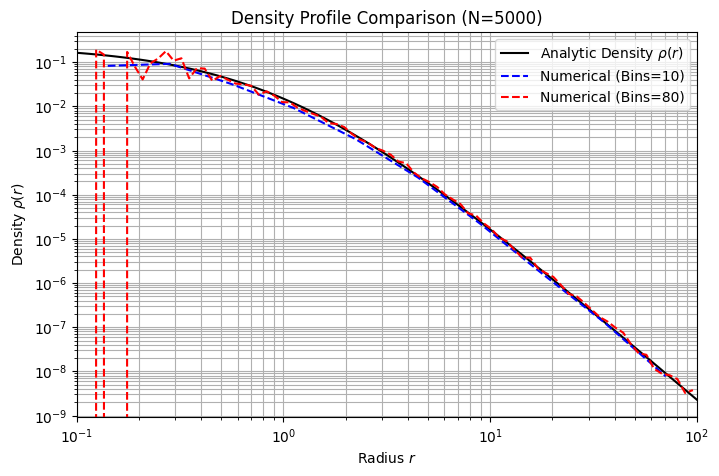

In [197]:
N_particles = 5000
pos, masses = generate_data(N=N_particles, q_max=0.002, r_trunc=100)

r_bins_low, rho_low = calculate_density_profile(pos, masses, n_bins=10)
r_bins_high, rho_high = calculate_density_profile(pos, masses, n_bins=80)

r_grid = np.logspace(-1, 2, 100)
rho_theory = analytic_rho(r_grid)

plt.figure(figsize=(8, 5))
plt.loglog(r_grid, rho_theory, 'k-', label='Analytic Density $\\rho(r)$')

plt.loglog(r_bins_low, rho_low, '--', color='blue', label=f'Numerical (Bins=10)')
plt.loglog(r_bins_high, rho_high, '--', color='red', label=f'Numerical (Bins=80)')

plt.xlabel('Radius $r$')
plt.ylabel('Density $\\rho(r)$')
plt.title(f'Density Profile Comparison (N={N_particles})')
plt.legend()
plt.grid(True, which="both")
plt.xlim(0.1, 100)

plt.show()

This demonstrates the trade-off in numerical analysis between resolution and noise. A smaller number of bins gives a smoother curve as the error bars are smaller due to the large number of particles in each bin. However, the spacial resolution is poor and it smears the profile. In constrast, a large number of bines gives a higher spatial resolution but the bins capture more noise, especially at large radii. Logarithmic binning helps balance this by making outer bins physically larger to capture more particles in the low-density regions.